### Likehood Surface Visualization

<br>**Author(s):** Weixiang Yu
<br>**Last run:** 07-30-20
<br>**Short description:** Notebook for developing the likelihood surface visualization function. 

In [1]:
# import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys

# see if local stores mpl style, else use from src
try:
    plt.style.use('yu_basic')
except:
    mpl.rc_file('https://raw.githubusercontent.com/ywx649999311/project_template'
                '/master/%7B%7Bcookiecutter.project_name%7D%7D/src/vis/mpl/yu_basic.rc')

pd.set_option('display.max_columns', 999)
%matplotlib inline

In [2]:
# import CARMA celerite term
from agntk.carma.CARMATerm import *
from agntk.lc.utils import *
from celerite import GP
from scipy.optimize import minimize

### 1. Simulate LC

In [3]:
# define GP model
kernel = DRW_term(np.log(0.25), np.log(15))
gp = GP(kernel)

In [4]:
# must do compute before simulate LC
npts = 100

# init with dense -> add season -> downsample
t_init = np.linspace(0, 3650, 10000)
yerr_init = np.random.normal(0, 1e-7, 10000) # give very tiny error
mask1 = add_season(t_init)
mask2 = downsample_byN(t_init[mask1], 100)
t = t_init[mask1][mask2]
yerr = yerr_init[mask1][mask2]

gp.compute(t, yerr)

# simulate LC
y = gp.sample()

Text(0.5, 1.0, 'Sample Simulated DRW LC')

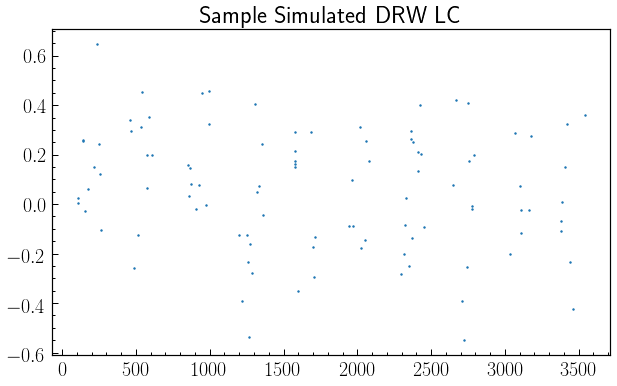

In [5]:
# # plot simulated LC
fig = plt.figure(figsize=(10,6))
plt.scatter(t, y, s=2)
plt.title('Sample Simulated DRW LC')

### 2. Generate best-fits & Eval LL Surface
#### 2.1 First fit using optimizer

In [6]:
# define log posterior function
def neg_log_like(params, y, yerr, gp):
    params = np.array(params)
    # pure likelihood based
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)


# define log posterior function
def neg_log_prob(params, y, yerr, gp):
    gp.set_parameter_vector(params)
    amp = gp.kernel.get_rms_amp()
    model_std = np.sqrt(np.var(y) - np.var(yerr))
    
    # below add a prior using the estimated model std from light curve
    return -gp.log_likelihood(y) + 100*(amp - model_std)**2/2

# # define vectorized version
vec_neg_log_like = np.vectorize(neg_log_like, excluded=[1,2,3], signature='(n)->()')
vec_neg_log_prob = np.vectorize(neg_log_prob, excluded=[1,2,3], signature='(n)->()')

In [7]:
def fitDRW(t, y, yerr, prob_func):
    # check dimention dismatch
    assert (len(t) == len(yerr)) & (len(t) == len(y)), 'Data dimension dismatch.'
    
    ## start fitting
    # initialize parameter in the possible range
    init_tau = np.exp(np.random.uniform(1, np.log(700), 1)[0])
    init_amp = np.random.uniform(0, 0.35, 1)[0]

    kernel_fit = DRW_term(np.log(init_amp), np.log(init_tau))
    gp_fit = GP(kernel_fit)
    gp_fit.compute(t, yerr)

    initial_params = gp_fit.get_parameter_vector()
    bounds = gp_fit.get_parameter_bounds()

    r = minimize(prob_func, initial_params, method="L-BFGS-B", bounds=bounds, \
                 args=(y, yerr, gp_fit))
    
    return r.x

In [8]:
# fit with log_like or log_prob
ll_fit = np.exp(fitDRW(t, y, yerr, neg_log_like))
lp_fit = np.exp(fitDRW(t, y, yerr, neg_log_prob))

print(f'LogLikelihood best-fit: {ll_fit}')
print(f'Log Prob best-fit: {lp_fit}')

LogLikelihood best-fit: [ 0.24834343 12.46187225]
Log Prob best-fit: [ 0.24800946 12.43533932]


#### 1.2 Check out the likelihood surface

In [9]:
# eval likelihood surface
# init grid, range is 1 times best-fit
tau_min, tau_max = (0.5*ll_fit[1], 1.5*ll_fit[1])
amp_min, amp_max = (0.5*ll_fit[0], 1.5*ll_fit[0])

grid_dim = 100
taus = np.log(np.logspace(np.log10(tau_min), np.log10(tau_max), grid_dim))
amps = np.log(np.linspace(amp_min, amp_max, grid_dim))

In [10]:
param_grid = np.meshgrid(amps, taus) # log scale
reg_param_grid = np.exp(param_grid) # normal scale

# flatten to list
ls_params_combo = list(zip(param_grid[0].flatten(), param_grid[1].flatten())) 

# run in bulk
bulk_ll = vec_neg_log_like(ls_params_combo, y, yerr, gp)
ll_reshape = bulk_ll.reshape((grid_dim,grid_dim))

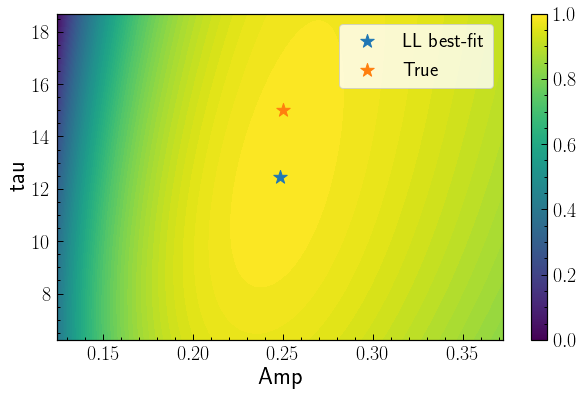

In [14]:
# plot
nLevels = 100
fig = plt.figure(figsize=(10,6))
plt.contourf(reg_param_grid[0], reg_param_grid[1], -ll_reshape, nLevels)
# plt.contour(reg_grid[0], reg_grid[1], -ll_reshape, nLevels,colors="white")
plt.xlabel("Amp")
plt.ylabel("tau")
plt.scatter(ll_fit[0], ll_fit[1], marker='*', s=200, \
            label='LL best-fit')
plt.scatter(0.25, 15, marker='*', s=200, label='True')
plt.colorbar()
plt.legend()

<span style='color:red'>Based on the likelihood surface plot, we can see the algorithm indeed found the best solution given the surface, but the best-fit doesn't agree with the input used. </span>

#### 1.2 Check out the custom probability surface

In [15]:
# eval likelihood surface
# init grid, range is 1 times best-fit
tau_min, tau_max = (0.5*lp_fit[1], 1.5*lp_fit[1])
amp_min, amp_max = (0.5*lp_fit[0], 1.5*lp_fit[0])

grid_dim = 100
taus = np.log(np.logspace(np.log10(tau_min), np.log10(tau_max), grid_dim))
amps = np.log(np.linspace(amp_min, amp_max, grid_dim))

In [16]:
param_grid = np.meshgrid(amps, taus) # log scale
reg_param_grid = np.exp(param_grid) # normal scale

# flatten to list
ls_params_combo = list(zip(param_grid[0].flatten(), param_grid[1].flatten())) 

# run in bulk
bulk_lp = vec_neg_log_like(ls_params_combo, y, yerr, gp)
lp_reshape = bulk_lp.reshape((grid_dim,grid_dim))

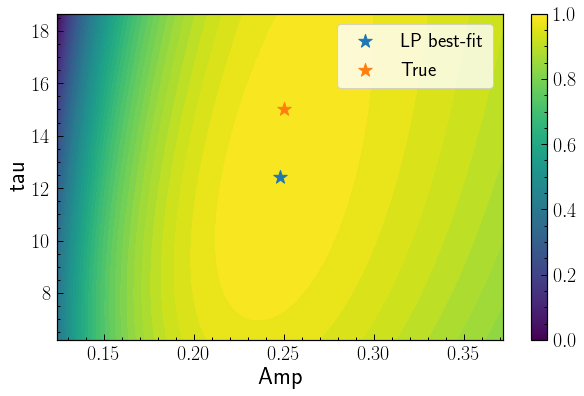

In [17]:
# plot
nLevels = 50
fig = plt.figure(figsize=(10,6))
plt.contourf(reg_param_grid[0], reg_param_grid[1], -lp_reshape, nLevels)
# plt.contour(reg_grid[0], reg_grid[1], -ll_reshape, nLevels,colors="white")
plt.xlabel("Amp")
plt.ylabel("tau")
plt.scatter(lp_fit[0], lp_fit[1], marker='*', s=200, \
            label='LP best-fit')
plt.scatter(0.25, 15, marker='*', s=200, label='True')
plt.colorbar()
plt.legend()

<span style='color:red'>Similar conclusion applied to the customized posterior surface. </span>

### 3. Put above code into a function

In [18]:
def plot_drw_ll(t, y, yerr, best_params, gp, prob_func, amp_range=None, tau_range=None, **kwargs):

    best_amp, best_tau = best_params
    grid_size = 50
    
    if amp_range is None:
        amp_range = [0.5*best_amp, 1.5*best_amp]
    if tau_range is None:
        tau_range = [0.5*best_tau, 1.5*best_tau]
    
    # check if custom resoultion
    if 'grid_size' in kwargs:
        grid_size = int(kwargs.get('grid_size'))
        
    taus = np.log(np.logspace(np.log10(tau_range[0]), np.log10(tau_range[1]), grid_size))
    amps = np.log(np.linspace(amp_range[0], amp_range[1], grid_size))
    
    param_grid = np.meshgrid(amps, taus) # log scale
    reg_param_grid = np.exp(param_grid) # normal scale

    # flatten to list
    ls_params_combo = list(zip(param_grid[0].flatten(), param_grid[1].flatten())) 

    # run in bulk
    gp.compute(t, yerr)
    bulk_lp = prob_func(ls_params_combo, y, yerr, gp)
    lp_reshape = bulk_lp.reshape((grid_size, grid_size))
    
    fig = plt.figure(figsize=(10,6))
    plt.contourf(reg_param_grid[0], reg_param_grid[1], -lp_reshape, nLevels)
    plt.title('Likelihood Surface')
    plt.xlabel("Amp")
    plt.ylabel("Tau")
    plt.scatter(best_params[0], best_params[1], marker='*', s=200, \
                label='Best-fit')

    if 'true_params' in kwargs:
        true_params = kwargs.get('true_params')
        plt.scatter(true_params[0], true_params[1], marker='*', s=200, \
            label='True')

    plt.colorbar()
    plt.legend()

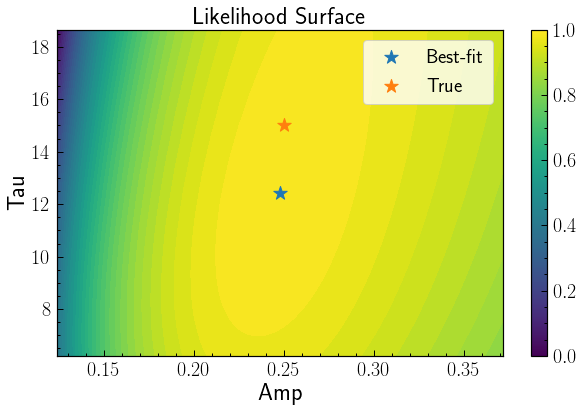

In [19]:
plot_drw_ll(t, y, yerr, lp_fit, gp, vec_neg_log_like, true_params=[0.25, 15])